In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import collections
import copy

In [2]:
def gen_data(n, mu, sigma, p):
    labels = torch.bernoulli(torch.Tensor(n, 1).fill_(p))
    clusterId = torch.bernoulli(torch.Tensor(n, 1).fill_(0.75)).long()
    ones = torch.normal(mu*(2*clusterId-1), sigma)
    zeros = torch.normal(-mu*(2*clusterId-1), sigma)
    data = torch.where(labels==1, ones, zeros)
    return data, labels

In [3]:
def resample(xs, ys, n):
    def sample(xs, n):
        idxs = torch.randint(0, len(xs), (n,))
        return xs[idxs]
    xNew = sample(xs[ys==1], n//2)
    xNew = torch.cat([xNew, sample(xs[ys==0], n//2)])
    return xNew.unsqueeze(1)

def obtain_confusion_matrix(model, xs, ys):
    outputs = model(xs)
    probsPred = torch.sigmoid(outputs)
    labelPreds = (probsPred > 0.5).float().detach()
    confusion = torch.zeros(2, 2)
    confusion[0, 0] = torch.sum((labelPreds == 0) & (ys == 0))
    confusion[0, 1] = torch.sum((labelPreds == 0) & (ys == 1))
    confusion[1, 0] = torch.sum((labelPreds == 1) & (ys == 0))
    confusion[1, 1] = torch.sum((labelPreds == 1) & (ys == 1))
    confusion = confusion / len(xs)
    return confusion

def reweight(model, xTarget, xSource, ys):
    '''
    Reweights the data using the model and returns the reweighted data.
    '''
    targetOutputs = model(xTarget)
    targetProbsPred = torch.sigmoid(targetOutputs)
    targetLabelPreds = (targetProbsPred > 0.5).float().detach()
    confusion = obtain_confusion_matrix(model, xSource, ys)
    mu = torch.zeros(2)
    mu[0] = torch.sum((targetLabelPreds == 0))/len(xTarget)
    mu[1] = torch.sum((targetLabelPreds == 1))/len(xTarget)
    
    w = torch.inverse(confusion) @ mu
    return w

def adapt(model, xTarget, xSource, ySource, epochs = 10000, lr = 0.00002, RW = True, RS = True):
    '''
    Adapts the model to the target dataset and returns the adapted model.
    Current code uses Adam since the SGD was very slow.
    '''
    if RW:
        models = [(copy.deepcopy(model), reweight(model, xTarget, xSource, ySource))]
    else:
        models = [(copy.deepcopy(model), torch.ones(2))]
    optimizer = torch.optim.Adam(model[0].parameters(), lr=lr)
    xs = xTarget.clone()
    for i in tqdm(range(epochs)):
        optimizer.zero_grad()
        outputs = model[0](xTarget)
        
        probsPred = torch.sigmoid(outputs)
        labelPreds = (probsPred > 0.5).float().detach()
        if RS:
            xs = resample(xTarget, labelPreds, len(xTarget))

        optimizer.zero_grad()
        outputs = model(xs)
        
        probsPred = torch.sigmoid(outputs)
        labelPreds = (probsPred > 0.5).float().detach()
        
        loss = F.binary_cross_entropy(probsPred, labelPreds)
        loss.backward()    
        optimizer.step()
        
        if i % 100 == 0:
            if RW:
                models.append((copy.deepcopy(model), reweight(model, xTarget, xSource, ySource)))
            else:
                models.append((copy.deepcopy(model), torch.ones(2)))
    
    return models

In [4]:
def grad_by_data_on_model(model, xs):
    model.zero_grad()
    probPred = torch.sigmoid(model(xs))
    labelPred = (probPred > 0.5).float().detach()
    loss = F.binary_cross_entropy(probPred, labelPred)
    loss.backward()
    return model[0].weight.grad.data.clone(), model[0].bias.grad.data.clone()

In [5]:
def evaluate(rModel, x, y):
    model = rModel[0]
    rw = rModel[1]
    probPred = torch.sigmoid(model(x)) * rw
    labelPred = ((probPred * rw[1])/ (probPred * rw[1] + (1-probPred) * rw[0]) > 0.5).float().detach()
    acc = torch.mean((labelPred == y).float())
    return acc    

In [6]:
def plot_decision_boundaryV(model, x):
    w, b = model[0].weight[0].item(), model[0].bias.item()
    x0 = -b/w
    plt.axvline(x0, color='r')

def plot_decision_boundaryH(model, title, ax, c):
    w, b = model[0].weight[0].item(), model[0].bias.item()
    x0 = -b/w
    ax.axhline(x0, color=c, alpha=0.5, label=title)

In [7]:
n = 5000
d = 1
mu = 2.
sigma = 1.
pSource = 0.5
pTarget = 0.95

In [8]:
xSourceTrain, ySourceTrain = gen_data(n, mu, sigma, pSource)
xSourceTest, ySourceTest = gen_data(n, mu, sigma, pSource)

xTargetTrain, yTargetTrain = gen_data(n, mu, sigma, pTarget)
xTargetTest, yTargetTest = gen_data(n, mu, sigma, pTarget)

In [9]:
model = nn.Sequential(nn.Linear(1, 1))
model[0].weight.data = torch.tensor([[1.]]).float()
model[0].bias.data = -torch.tensor(torch.sum(torch.mean(xSourceTrain, dim=0))).float()

/var/folders/_x/wtryhxsj37vd8b_d3pb8klt40000gn/T/ipykernel_52662/857620759.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model[0].bias.data = -torch.tensor(torch.sum(torch.mean(xSourceTrain, dim=0))).float()


In [10]:
iterations, lr = 5_000_00, 0.00002
adaptedModel = copy.deepcopy(model)
adaptedModels = adapt(adaptedModel, xTargetTrain, xSourceTrain, ySourceTrain, epochs=iterations, lr=lr, RW=True, RS = False)

100%|██████████| 500000/500000 [04:40<00:00, 1780.25it/s]


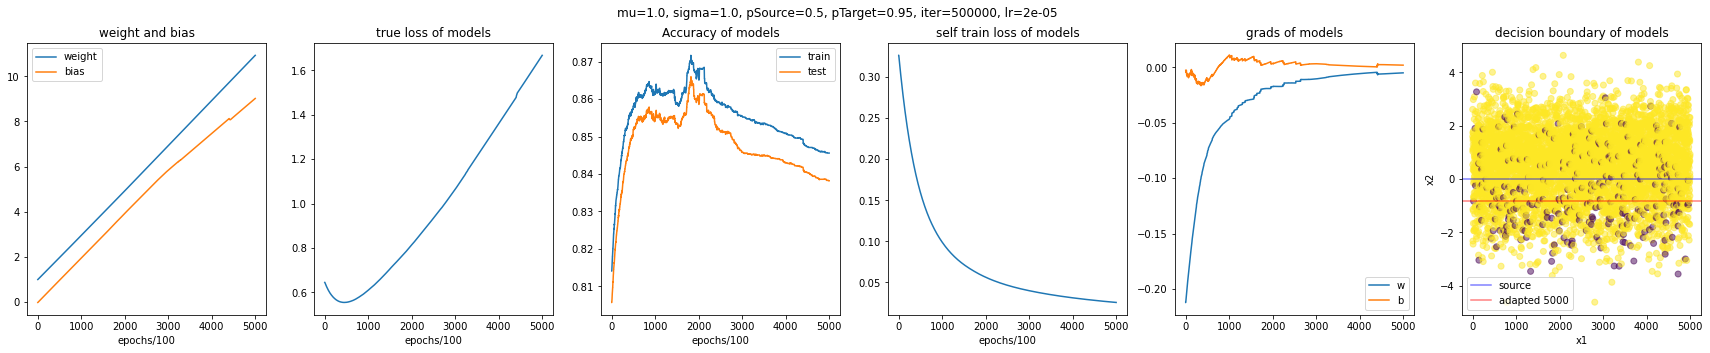

In [32]:
f, ax = plt.subplots(1, 6, figsize=(30, 5))
normsOfModels = [torch.norm(model[0][0].weight.data).item() for model in adaptedModels]
trueLossOfModels = [F.binary_cross_entropy_with_logits(model[0](xTargetTrain), yTargetTrain).detach() for model in adaptedModels]
trainAccuracyOfModels = [evaluate(model, xTargetTrain, yTargetTrain) for model in adaptedModels]
testAccuracyOfModels = [evaluate(model, xTargetTest, yTargetTest) for model in adaptedModels]
gradsW1Pos = []
gradsW1Neg = []
gradsW2Pos = []
gradsW2Neg = []
gradsB1Pos = []
gradsB1Neg = []
for model in adaptedModels:
    gradW1Pos, gradB1Pos = grad_by_data_on_model(model[0], xTargetTrain[yTargetTrain[:,0] == 1])
    gradW1Neg, gradB1Neg = grad_by_data_on_model(model[0], xTargetTrain[yTargetTrain[:,0] == 0])
    gradsW1Pos.append(gradW1Pos[0,0].item())
    gradsW1Neg.append(gradW1Neg[0,0].item())
    gradsB1Pos.append(gradB1Pos.item())
    gradsB1Neg.append(gradB1Neg.item())
    

selfTrainLossOfModels = []
for model in adaptedModels:
    probPred = torch.sigmoid(model[0](xTargetTrain))
    labelPred = (probPred > 0.5).float()
    selfTrainLossOfModels.append(F.binary_cross_entropy(probPred, labelPred).detach())

ax[0].plot(normsOfModels, label = 'weight')
ax[0].plot([model[0][0].bias.data.item() for model in adaptedModels], label = 'bias')
ax[0].set_title('weight and bias')
ax[0].set_xlabel('epochs/100')
ax[0].legend()
ax[1].plot(trueLossOfModels)
ax[1].set_title('true loss of models')
ax[1].set_xlabel('epochs/100')
ax[2].plot(trainAccuracyOfModels)
ax[2].plot(testAccuracyOfModels)
ax[2].set_title('Accuracy of models')
ax[2].legend(['train', 'test'])
ax[2].set_xlabel('epochs/100')
ax[3].plot(selfTrainLossOfModels)
ax[3].set_title('self train loss of models')
ax[3].set_xlabel('epochs/100')
# ax[4].plot(gradsW1Pos, alpha=0.3)
# ax[4].plot(gradsW1Neg, alpha=0.3)
# ax[4].plot(gradsB1Pos, alpha=0.3)
# ax[4].plot(gradsB1Neg, alpha=0.3)
ax[4].plot((np.array(gradsW1Pos) + np.array(gradsW1Neg))/2, alpha=1)
ax[4].plot((np.array(gradsB1Pos) + np.array(gradsB1Neg))/2, alpha=1)
ax[4].set_title('grads of models')
ax[4].legend(['w', 'b'])
plot_decision_boundaryH(adaptedModels[0][0], 'source', ax[5], 'b')
# plot_decision_boundaryH(adaptedModels[2000][0], 'adapted 2000', ax[5], 'g')
# plot_decision_boundaryH(adaptedModels[4000][0], 'adapted 4000', ax[5], 'orange')
plot_decision_boundaryH(adaptedModels[-1][0], 'adapted 5000', ax[5], 'r')
plt.scatter(list(range(n)), xTargetTrain, c=yTargetTrain, alpha=0.5)
ax[5].set_xlabel('x1')
ax[5].set_ylabel('x2')
ax[5].set_title('decision boundary of models')
f.suptitle('mu={}, sigma={}, pSource={}, pTarget={}, iter={}, lr={}'.format(mu, sigma, pSource, pTarget, iterations, lr))
plt.legend()
plt.show()

In [12]:
for model, rw in adaptedModels:
    print(rw)
    

tensor([0.0664, 1.9601])
tensor([0.0664, 1.9601])
tensor([0.0675, 1.9590])
tensor([0.0664, 1.9601])
tensor([0.0689, 1.9576])
tensor([0.0676, 1.9589])
tensor([0.0714, 1.9550])
tensor([0.0702, 1.9562])
tensor([0.0703, 1.9561])
tensor([0.0692, 1.9573])
tensor([0.0726, 1.9538])
tensor([0.0737, 1.9526])
tensor([0.0678, 1.9587])
tensor([0.0702, 1.9562])
tensor([0.0690, 1.9574])
tensor([0.0655, 1.9611])
tensor([0.0610, 1.9657])
tensor([0.0599, 1.9668])
tensor([0.0610, 1.9656])
tensor([0.0600, 1.9667])
tensor([0.0517, 1.9752])
tensor([0.0517, 1.9752])
tensor([0.0481, 1.9789])
tensor([0.0496, 1.9774])
tensor([0.0495, 1.9775])
tensor([0.0508, 1.9761])
tensor([0.0460, 1.9811])
tensor([0.0425, 1.9847])
tensor([0.0414, 1.9858])
tensor([0.0366, 1.9907])
tensor([0.0378, 1.9895])
tensor([0.0367, 1.9906])
tensor([0.0379, 1.9894])
tensor([0.0368, 1.9906])
tensor([0.0380, 1.9893])
tensor([0.0369, 1.9904])
tensor([0.0394, 1.9879])
tensor([0.0382, 1.9892])
tensor([0.0394, 1.9878])
tensor([0.0358, 1.9916])


In [11]:
model = nn.Sequential(nn.Linear(1, 1))
model[0].weight.data = torch.tensor([[1.]]).float()
model[0].bias.data = torch.tensor(10.).float()

In [14]:
evaluate((model, torch.ones(2)), xTargetTrain, yTargetTrain)

tensor(0.9514)